In [ ]:
#!pip install --upgrade tensorflow==2.4
#!pip ⁷install --upgrade tensorflow-probability==0.12

In [ ]:
!nvidia-smi

Mon Jul 22 15:40:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
try:
  import mat73
except:
  !pip install mat73
  import mat73

In [ ]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import seaborn as sns
import time
import pandas as pd
import scipy
import scipy.io
import seaborn as sns
from numpy import linalg as LA
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils.extmath import randomized_svd
from matplotlib.animation import FuncAnimation, writers

from skimage import img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

#from keras.callbacks import Callback

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv2D, ConvLSTM2D, Conv2DTranspose, Flatten, Reshape, LeakyReLU, ReLU, Input
from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, UpSampling2D, TimeDistributed, LayerNormalization, Add
from tensorflow.keras.layers import Dropout, BatchNormalization

In [ ]:
font = {'size'   : 18}

matplotlib.rc('font', **font)

In [ ]:
print(tf.__version__)
print(tfp.__version__)

tf.test.gpu_device_name()

2.15.0
0.23.0


'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1556602363494923220
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6533960829919780151
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
seed = 325735283
tf.random.set_seed(seed)

# 1. Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# set working directory
import os
os.chdir("//content/drive/My Drive/abadiaheredia_etal_2024/")

In [ ]:
data_dict = mat73.loadmat('DATA/dataset_experimental.mat')

Ten_orig_1 = data_dict['Tensor'][0:1,:,:,:]

# SVD

In [ ]:
train_set_1 = np.copy(Ten_orig_1[:1,...,:int(0.7*Ten_orig_1.shape[-1])])

train_mean = np.mean(np.copy(Ten_orig_1[:1,...,:int(0.7*Ten_orig_1.shape[-1])]), axis = -1)

train_set_1 = train_set_1 - train_mean[..., None]

In [ ]:
Utr, Str, VTtr = LA.svd(
    np.reshape(
        np.copy(train_set_1),
        [np.product(train_set_1.shape[:-1]), train_set_1.shape[-1]],
        order = 'F'),
    full_matrices = False)

In [ ]:
num_modes = 100
train_set_recon = np.dot(Utr[:,:num_modes], np.dot(np.diag(Str[:num_modes]), VTtr[:num_modes,:]))
train_set_recon = np.reshape(train_set_recon, [1,111,301,train_set_1.shape[-1]], order = 'F')
train_set_recon = train_set_recon + train_mean[..., None]

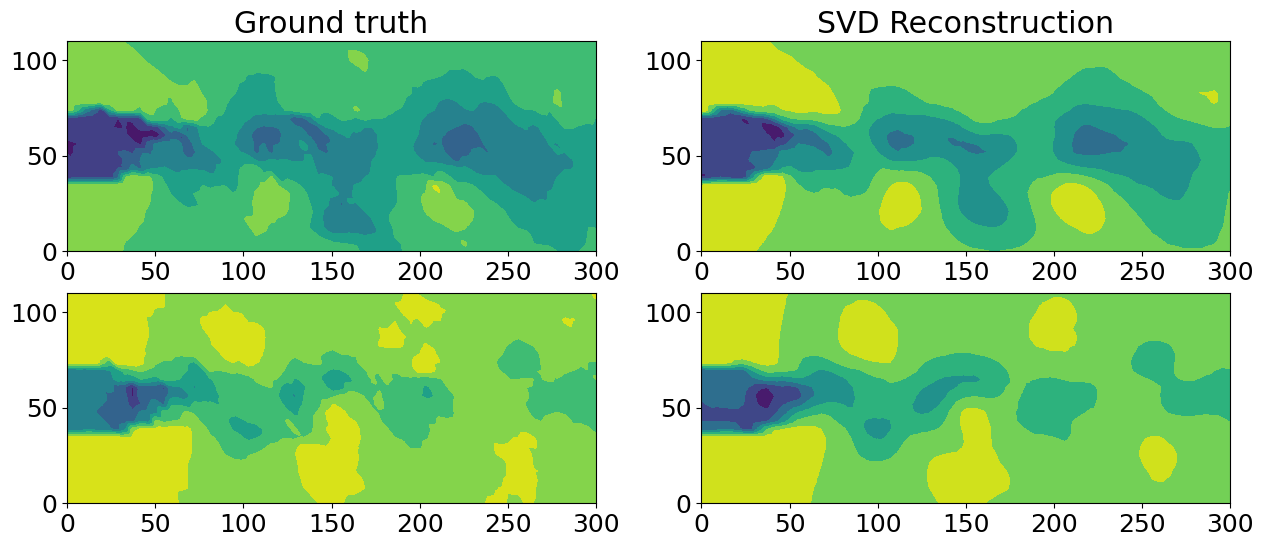

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (15,6))
axs[0,0].contourf(Ten_orig_1[0,:,:,100])
axs[0,0].set_title('Ground truth')
axs[0,1].contourf(train_set_recon[0,:,:,100])
axs[0,1].set_title('SVD Reconstruction')

axs[1,0].contourf(Ten_orig_1[0,:,:,200])
axs[1,1].contourf(train_set_recon[0,:,:,200])

In [ ]:
# Scailing between 0 and 1
ten_min = np.amin(train_set_recon)
ten_range = np.ptp(train_set_recon)

train_set = (train_set_recon - ten_min) / ten_range

# Channels last, time first
train_set = np.transpose(train_set, (3, 1, 2, 0))

print(f"Train set shape: {train_set.shape}")

Train set shape: (2800, 111, 301, 1)
Dev set shape: (200, 111, 301, 1)


In [ ]:
print(np.amin(train_set))
print(np.amax(train_set))
print(np.mean(train_set))
print(np.std(train_set))

0.0
1.0
0.6737263115227213
0.08766775626404696


# 2. Data Split

In [ ]:
train_set = np.copy(train_set_recon[:1,...,:int(0.7*train_set_recon.shape[-1])]) # 0.4
dev_set = np.copy(train_set_recon[:1,...,int(0.65*train_set_recon.shape[-1]):int(0.7*train_set_recon.shape[-1])])

# Scailing between 0 and 1
ten_min = np.amin(train_set)
ten_range = np.ptp(train_set)

# ten_min = np.mean(train_set, axis = -1)[..., None]
# ten_range = np.std(train_set, axis = -1)[..., None]

train_set = (train_set - ten_min) / ten_range
dev_set = (dev_set - ten_min) / ten_range

# Channels last, time first
train_set = np.transpose(train_set, (3, 1, 2, 0))
dev_set = np.transpose(dev_set, (3, 1, 2, 0))

print(f"Train set shape: {train_set.shape}")
print(f"Dev set shape: {dev_set.shape}")

Train set shape: (1959, 111, 301, 1)
Dev set shape: (139, 111, 301, 1)


In [ ]:
print(np.amin(train_set))
print(np.amax(train_set))
print(np.mean(train_set))
print(np.std(train_set))

0.0
1.0
0.6660112334300686
0.09010522008172037


# 3. Data Windowing

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, samplingRate, batch_size,
            train_df, val_df, test_df):

        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.sampling_rate = samplingRate

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}'])

def split_window(self, features):
    inputs = features[:, self.input_slice, ...]
    labels = features[:, self.labels_slice, ...]

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None, None, None])
    labels.set_shape([None, self.label_width, None, None, None])

    return inputs, labels

WindowGenerator.split_window = split_window

def make_dataset(self, data, state):
    data = np.array(data, dtype=np.float32)
    if (state == "training"):
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data = data,
            targets = None,
            sequence_length = self.total_window_size,
            sequence_stride = 1,
            sampling_rate = self.sampling_rate,
            shuffle = True,
            batch_size = self.batch_size)

    else:
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data = data,
            targets = None,
            sequence_length = self.total_window_size,
            sequence_stride = 1,
            sampling_rate = self.sampling_rate,
            shuffle = False,
            batch_size = self.batch_size)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self, state = "training"):
    return self.make_dataset(self.train_df, state)

@property
def val(self, state = "not_training"):
    return self.make_dataset(self.val_df, state)

@property
def test(self, state = "not_training"):
    return self.make_dataset(self.test_df, state)

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test

In [ ]:
inputWidth = 5
labelWidth = 1
shift = 1

batchSize = 8 #32 #16 #8

w1 = WindowGenerator(input_width = inputWidth, label_width = labelWidth,
                     shift = shift, samplingRate = 1, batch_size = batchSize,
                     train_df = train_set,
                     val_df = dev_set,
                     test_df = train_set)

In [ ]:
print(f"Number of training batches: {len(w1.train)}")

for example_inputs, example_labels in w1.train.take(1):
  in_shape = (example_inputs.shape[1], example_inputs.shape[2], example_inputs.shape[3], example_inputs.shape[4])
  print(f'\nInputs shape (batch size, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch size, time, features): {example_labels.shape}')

Number of training batches: 245

Inputs shape (batch size, time, features): (8, 5, 111, 301, 1)
Labels shape (batch size, time, features): (8, 1, 111, 301, 1)


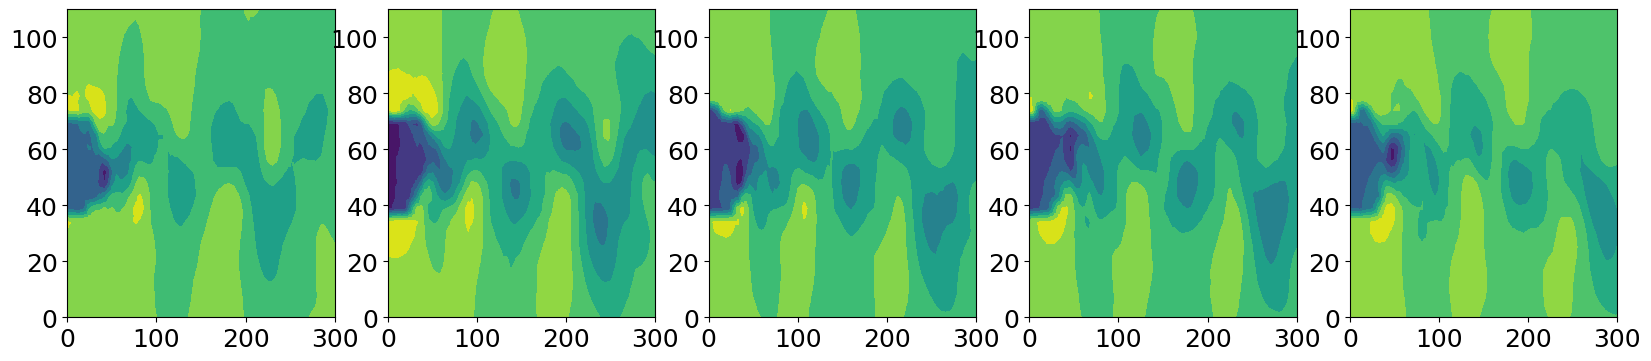

In [ ]:
plt.close('all')

fig = plt.figure(figsize = (20, 4))

plt.subplot(1,5,1)
plt.contourf(example_inputs[0,0,:,:,0])

plt.subplot(1,5,2)
plt.contourf(example_inputs[0,1,:,:,0])

plt.subplot(1,5,3)
plt.contourf(example_inputs[0,2,:,:,0])

plt.subplot(1,5,4)
plt.contourf(example_inputs[0,3,:,:,0])

plt.subplot(1,5,5)
plt.contourf(example_inputs[0,4,:,:,0])

In [ ]:
del train_set, dev_set

# KL regularizer Distribution

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def get_kl_regularizer(latent_dim):
  """
  The prior of latent variables is considered a standard Normal distribution.
  Therefore this function creates the KLDivergenceRegularizer that will be used
  in the ELBO.
  """

  return tfpl.KLDivergenceRegularizer(
      tfd.MultivariateNormalDiag(loc = tf.zeros(latent_dim),
                                 scale_diag = tf.ones(latent_dim)),
      use_exact_kl = False,
      test_points_fn = lambda q: q.sample(30),
      weight = 1.0,
      test_points_reduce_axis = None)

# 4. Variational Autoencoder

## Inference

In [ ]:
def get_encoder(latent_dim, in_shape, kl_regularizer):

  model = Sequential([
      Input(shape = in_shape),

      Conv2D(filters=2, kernel_size=7, strides=(1,2), padding='valid',
             data_format='channels_last', kernel_initializer='he_uniform'),
      ReLU(),
      LayerNormalization(),

      Conv2D(filters=4, kernel_size=5, strides=2, padding='valid',
             data_format='channels_last', kernel_initializer='he_uniform'),
      ReLU(),
      LayerNormalization(),

      Conv2D(filters=16, kernel_size=3, strides=(2,2), padding='valid',
             data_format='channels_last', kernel_initializer='he_uniform'),
      ReLU(),
      LayerNormalization(),

      Conv2D(filters=32, kernel_size=3, strides=(2,2), padding='valid',
             data_format='channels_last', kernel_initializer='he_uniform'),
      ReLU(),
      LayerNormalization(),

      Conv2D(filters=64, kernel_size=3, strides=(1,1), padding='valid',
             data_format='channels_last', kernel_initializer='he_uniform'),
      ReLU(),
      LayerNormalization(),

      ConvLSTM2D(64, (3, 3), strides = (1,1), padding="same",
                 return_sequences=False, data_format='channels_last'),
      LayerNormalization(),

      Flatten(),
      Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim), activation=None),

      tfpl.MultivariateNormalTriL(latent_dim,
        convert_to_tensor_fn = tfp.distributions.Distribution.sample,
        activity_regularizer = kl_regularizer)

  ], name='encoder')

  return model

## Generation

In [ ]:
def get_decoder(latent_dim, num_kernels):

  inputs = Input(shape=(latent_dim,))

  x = Dense(units=9600, activation='relu',
            kernel_initializer='he_uniform')(inputs)
  x = Reshape((10,15,64))(x)

  x = Conv2DTranspose(filters=64, kernel_size=7, strides=2, padding='valid',
                      data_format='channels_last', activation='relu',
                      kernel_initializer='he_uniform')(x)
  x = ReLU()(x)
  x = tf.keras.layers.LayerNormalization()(x)

  x_probs = Flatten()(x)
  x_probs = Dense(num_kernels, activation='softmax')(x_probs)

  x = Conv2DTranspose(filters=32, kernel_size=5, strides=2, padding='valid',
                      data_format='channels_last', activation='relu',
                      kernel_initializer='he_uniform')(x)
  x = ReLU()(x)
  x = tf.keras.layers.LayerNormalization()(x)

  x = Conv2DTranspose(filters=16, kernel_size=(3,3), strides=2, padding='valid',
                      data_format='channels_last', activation='relu',
                      kernel_initializer='he_uniform')(x)
  x = ReLU()(x)
  x = tf.keras.layers.LayerNormalization()(x)

  x = Conv2DTranspose(filters=8, kernel_size=(3,5), strides=(1,2), padding='valid',
                      data_format='channels_last', activation='relu',
                      kernel_initializer='he_uniform')(x)
  x = ReLU()(x)
  x = tf.keras.layers.LayerNormalization()(x)

  x = Conv2DTranspose(filters=8, kernel_size=(3,5), strides=(1,1), padding='valid',
                      data_format='channels_last', activation='relu',
                      kernel_initializer='he_uniform')(x)
  x = ReLU()(x)
  x = tf.keras.layers.LayerNormalization()(x)



  x = Conv2D(filters=2*num_kernels, kernel_size=1, strides=1, activation=None,
             padding='valid', data_format='channels_last')(x)
  x = tf.transpose(x, perm = [0,3,1,2])

  x = [x_probs, x]

  outputs = tfpl.DistributionLambda(
    lambda t: tfd.MixtureSameFamily(
        mixture_distribution = tfd.Categorical(probs=t[0]),
        components_distribution = tfd.Independent(
            tfd.MultivariateNormalDiag(loc=t[1][:,:num_kernels,...],
                                       scale_diag=tf.nn.softplus(t[1][:,num_kernels:,...])
                                       ),
                                       reinterpreted_batch_ndims=1
            )
        )
    )(x)

  return Model(inputs=inputs, outputs=outputs, name='decoder')

## VAE

In [ ]:
tf.keras.backend.clear_session()

latent_dim = 25
num_kernels_enc = 7
num_kernels_dec = 15

kl_regularizer = get_kl_regularizer(latent_dim)

encoder = get_encoder(latent_dim, in_shape, kl_regularizer)

decoder = get_decoder(latent_dim, num_kernels_dec)

vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

# tf.keras.backend.clear_session()

# latent_dim = 25
# num_kernels_enc = 15
# num_kernels_dec = 15

# prior = get_prior(latent_dim = latent_dim)

# kl_regularizer = get_kl_regularizer(prior)

# encoder = get_encoder(latent_dim, in_shape, kl_regularizer) #_2

# decoder = get_decoder(latent_dim, num_kernels_dec) #_2

# vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

In [ ]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 105, 148, 2)    100       
                                                                 
 re_lu (ReLU)                (None, 5, 105, 148, 2)    0         
                                                                 
 layer_normalization (Layer  (None, 5, 105, 148, 2)    4         
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 51, 72, 4)      204       
                                                                 
 re_lu_1 (ReLU)              (None, 5, 51, 72, 4)      0         
                                                                 
 layer_normalization_1 (Lay  (None, 5, 51, 72, 4)      8         
 erNormalization)                                          

In [ ]:
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 25)]                 0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 9600)                 249600    ['input_2[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 10, 15, 64)           0         ['dense_1[0][0]']             
                                                                                                  
 conv2d_transpose (Conv2DTr  (None, 25, 35, 64)           200768    ['reshape[0][0]']             
 anspose)                                                                                   

In [ ]:
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 111, 301, 1)   0         
                             ]                                   
                                                                 
 conv2d (Conv2D)             (None, 5, 105, 148, 2)    100       
                                                                 
 re_lu (ReLU)                (None, 5, 105, 148, 2)    0         
                                                                 
 layer_normalization (Layer  (None, 5, 105, 148, 2)    4         
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 51, 72, 4)      204       
                                                                 
 re_lu_1 (ReLU)              (None, 5, 51, 72, 4)      0     

# Loss Function

In [ ]:
def reconstruction_loss(target_modes, var_posterior):
    """
    This function defines the loss function. Note that only the log likelihood
    is implemented, because the KL term is already included in the encoder.
    """

    return(-tf.reduce_mean(var_posterior.log_prob(tf.squeeze(target_modes))))

# Training

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)

vae.compile(optimizer = optimizer, loss = reconstruction_loss)

In [ ]:
t0 = time.time()

history = vae.fit(w1.train, validation_data = w1.val, epochs = 14) # 15

t1 = time.time()

print(f"Training time {(t1 - t0)/60} minutes.")

Epoch 1/14
350/350 [==============================] - 89s 174ms/step - loss: -4304.1597 - val_loss: -21997.2676
Epoch 2/14
350/350 [==============================] - 58s 165ms/step - loss: -27832.6719 - val_loss: -34529.3047
Epoch 3/14
350/350 [==============================] - 58s 165ms/step - loss: -40029.7461 - val_loss: -45900.5234
Epoch 4/14
350/350 [==============================] - 58s 164ms/step - loss: -48999.9609 - val_loss: -51364.0352
Epoch 5/14
350/350 [==============================] - 58s 164ms/step - loss: -53343.7422 - val_loss: -54731.9688
Epoch 6/14
350/350 [==============================] - 58s 165ms/step - loss: -55728.6523 - val_loss: -56317.1250
Epoch 7/14
350/350 [==============================] - 57s 164ms/step - loss: -56872.4023 - val_loss: -57067.6406
Epoch 8/14
350/350 [==============================] - 57s 164ms/step - loss: -57437.7500 - val_loss: -57486.0703
Epoch 9/14
350/350 [==============================] - 57s 164ms/step - loss: -57854.7734 - val_lo

In [ ]:
ls CilindVKI_Results/

ResidualAE/  ResidualAEBothFlows/  ResidualAE_HODMD/  ResidualAE_NOMean/


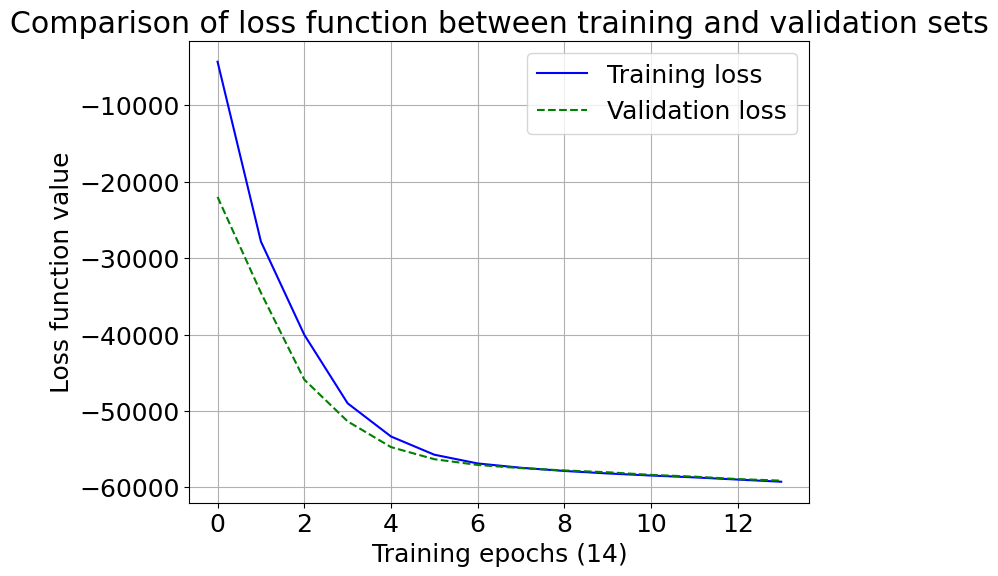

In [ ]:
font = {'size'   : 18}

matplotlib.rc('font', **font)

fig = plt.figure(figsize = (8, 6))
plt.plot(history.history['loss'], 'b', label = 'Training loss') # blue
plt.plot(history.history['val_loss'], 'g--', label = 'Validation loss') # green
plt.xlabel(f'Training epochs ({len(history.history["loss"])})')
plt.ylabel('Loss function value')
plt.title('Comparison of loss function between training and validation sets')
plt.grid()
plt.legend()

# Load model's weights

In [1]:
"""
vae.save_weights("./Models_weights/weights_vae_experimental_new.h5")
"""

# vae.load_weights("./Models_weights/weights_vae_experimental.h5")

'\nvae.save_weights("./Models_weights/weights_vae_experimental_new.h5")\n'

# Inference

In [ ]:
def evaluate_model_test_iter(ten_orig_1, time_pred = 10, start_pnt = 10):

  ten_orig = np.copy(ten_orig_1)

  predictions = np.empty((
      ten_orig.shape[0],
      ten_orig.shape[1],
      ten_orig.shape[2],
      time_pred
    ))

  snap = np.copy(ten_orig[0:1, ..., start_pnt-5:start_pnt])
  snap = (snap - ten_min) / ten_range
  snap = np.transpose(snap, [3,1,2,0])
  snap = snap[None, ...]

  for i in range(time_pred):

    pred = vae.predict(snap, verbose = 0)
    pred = pred[None,:,:,:,None]

    pred_1 = np.copy(pred[0,0,:,:,:]) * ten_range + ten_min
    pred_1 = np.transpose(pred_1, [2,0,1])

    predictions[...,i] = pred_1

    snap = np.concatenate([snap[:,1:,:,:,:], pred], axis = 1)

  del ten_orig, snap, pred, pred_1

  return predictions

In [ ]:
t0 = time.time()

start_pnt = train_set.shape[0]
predictions = evaluate_model_test_iter(train_set_recon, 200, start_pnt)

t1 = time.time()
print("Seconds elapsed: %f" % (t1 - t0))

Seconds elapsed: 16.358905


In [ ]:
data_dict = mat73.loadmat('DATA/dataset_experimental.mat')

Ten_1 = data_dict['Tensor']

Text(0.5, 1.0, 'Forecast')

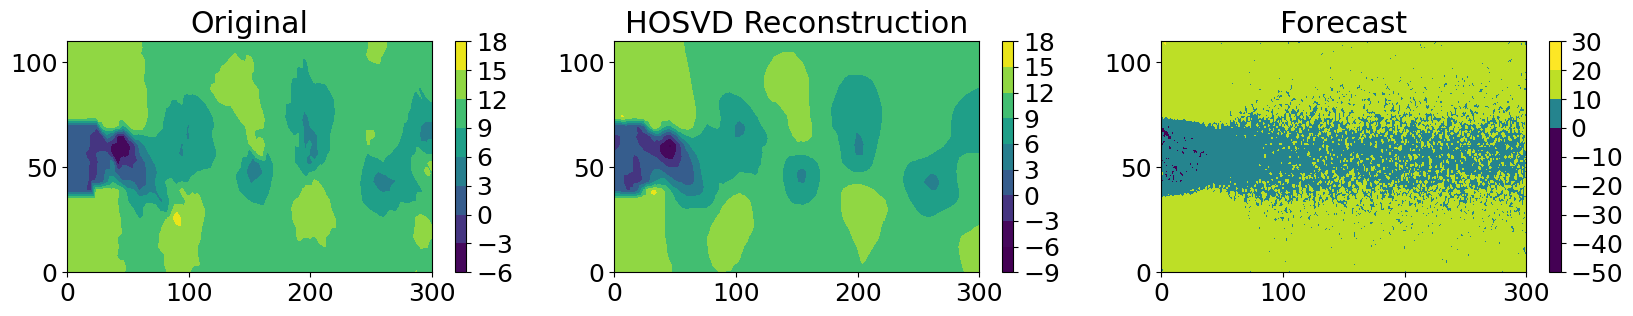

In [ ]:
select_snap = 100
comp = 0

snap_pred = predictions[comp,:,:,select_snap] #+ mean_flow[0,:,:,0]
snap_target_orig = Ten_1[comp,:,:,start_pnt + select_snap]
snap_target = train_set_recon[comp,:,:,start_pnt + select_snap]
diff = np.abs(snap_target - snap_pred)

fig3 = plt.figure(figsize=(20,3)) #(20,3)

vmin = np.amin(snap_target_orig)
vmax = np.amax(snap_target_orig)

plt.subplot(1, 3, 1)
plt.contourf(snap_target_orig, vmin = vmin, vmax = vmax)
plt.colorbar()
plt.title("Original")

plt.subplot(1, 3, 2)
plt.contourf(snap_target, vmin = vmin, vmax = vmax)
plt.colorbar()
plt.title("HOSVD Reconstruction")

plt.subplot(1, 3, 3)
plt.contourf(snap_pred, vmin = vmin, vmax = vmax)
plt.colorbar()
plt.title("Forecast")